#### Goal
This file aimed to test the needed functions one by one to see weather they provide the proper output. 

##### Import needed packegaes

In [1]:
from code_v1 import *

In [25]:
import matplotlib.pyplot as plt
from numba import jit 
import numpy as np 
import random 
import time 
from tqdm import tqdm 
from rich.progress import track 


##### initialize_lattice

In [21]:
def test_initialize_lattice():
    ''' 
    test if initailize type = code give all ones and type = hot give all 1 or -1 values
    '''
    test = True
    for N in range(1,5):
        if not np.array_equal(initialize_lattice(N).all, np.ones((N,N))):
            test == False
    for i in range(30):
        s = initialize_lattice(5, 'hot')
        for j in range(5):
            for k in range(5):
                if not (s[j][k] == 1 or s[j][k] == -1):
                    test = False
    
    if test:
        print(f"\nresult: {'All tests have passed' if test else 'failed'}")
    return test
test_initialize_lattice()


result: All tests have passed


True

##### compute_energy_change(lattice, i, j)

In [26]:
# input: surrent state s, locatoin of the element i,j 
# output: interaction energy between spins which is difference in energy due to flipping spin i,j 

def compute_energy_change_test():
    """
    testing for some special initial datas
    pass if all results have error less than 1e-10
    """
    
    test_cases = {
        "2x2_all_up": {
            "spins": np.ones((2, 2)),
            "name": "2x2 all up",
            "expected": {
                (0,0): 8.0, (0,1): 8.0,
                (1,0): 8.0, (1,1): 8.0
            }
        },
        
        "2x2_all_down": {
            "spins": -np.ones((2, 2)),
            "name": "2x2 all down", 
            "expected": {
                (0,0): 8.0, (0,1): 8.0,
                (1,0): 8.0, (1,1): 8.0
            }
        },
        
        "2x2_checkerboard": {
            "spins": np.array([[1, -1], 
                              [-1, 1]]),
            "name": "2x2_checkerboard",
            "expected": {
                (0,0): -8.0, (0,1): -8.0,
                (1,0): -8.0, (1,1): -8.0
            }
        },
        
        "2x2_single_down": {
            "spins": np.array([[1, 1], 
                              [1, -1]]),
            "name": "2x2 single down",
            "expected": {
                (0,0): 8.0, (0,1): 0.0,
                (1,0): 0.0, (1,1): -8.0
            }
        },
        
        "3x3_checkerboard": {
            "spins": np.array([[1, -1, 1],
                              [-1, 1, -1],
                              [1, -1, 1]]),
            "name": "3x3 checkerboard",
            "expected": {
                (0,0): 0.0, (0,1): -4.0, (0,2): 0.0,
                (1,0): -4.0, (1,1): -8.0, (1,2): -4.0,
                (2,0): 0.0, (2,1): -4.0, (2,2): 0.0
            }
        },
        
        "3x3_center_down": {
            "spins": np.array([[1, 1, 1],
                              [1, -1, 1],
                              [1, 1, 1]]),
            "name": "3x3 center down",
            "expected": {
                (0,0): 8.0, (0,1): 4.0, (0,2): 8.0,
                (1,0): 4.0, (1,1): -8.0, (1,2): 4.0,
                (2,0): 8.0, (2,1): 4.0, (2,2): 8.0
            }
        }
    }
    
    
    all_passed = True
    for name, data in test_cases.items():
        print(f"\n{data['name']}:")
        print(data['spins'])
        print()
        
        case_passed = True
        global L
        L = data['spins'].shape[0]
        
        for i in range(L):
            for j in range(L):
                calculated = compute_energy_change(data['spins'], i, j)
                passed = abs(calculated - data['expected'][(i,j)]) < 1e-10
                
                print(f"test {(i,j)}")
                print(f"  calculated value: {calculated}, expected value: {data['expected'][(i,j)]}")
                print(f"  {'pass' if passed else '! fail'}\n")
                
                if not passed:
                    case_passed = False
        
        print(f"\ntest: {data['name']} {'pass' if case_passed else '! fail'}\n")
        print("=" * 50)
                
        if not case_passed: 
            all_passed = False   
            
    print("=" * 50)
    print(f"result: {'All tests have passed' if all_passed else '! failed'}")
    return all_passed

compute_energy_change_test()


2x2 all up:
[[1. 1.]
 [1. 1.]]

test (0, 0)
  calculated value: 8.0, expected value: 8.0
  pass

test (0, 1)
  calculated value: 8.0, expected value: 8.0
  pass

test (1, 0)
  calculated value: 8.0, expected value: 8.0
  pass

test (1, 1)
  calculated value: 8.0, expected value: 8.0
  pass


test: 2x2 all up pass


2x2 all down:
[[-1. -1.]
 [-1. -1.]]

test (0, 0)
  calculated value: 8.0, expected value: 8.0
  pass

test (0, 1)
  calculated value: 8.0, expected value: 8.0
  pass

test (1, 0)
  calculated value: 8.0, expected value: 8.0
  pass

test (1, 1)
  calculated value: 8.0, expected value: 8.0
  pass


test: 2x2 all down pass


2x2_checkerboard:
[[ 1 -1]
 [-1  1]]

test (0, 0)
  calculated value: -8.0, expected value: -8.0
  pass

test (0, 1)
  calculated value: -8.0, expected value: -8.0
  pass

test (1, 0)
  calculated value: -8.0, expected value: -8.0
  pass

test (1, 1)
  calculated value: -8.0, expected value: -8.0
  pass


test: 2x2_checkerboard pass


2x2 single down:
[[ 

True

##### metropolis_single_flip(lattice, beta)

In [ ]:
def metropolis_single_flip_test():
    '''
    since random function is hard to test, this function only test if mc() takes correct input and proper output.
    '''
    test = True
    for i in range(30):
        global L
        L = random.randint(1,5)
        s = np.random.choice([1,-1],size=(L,L))
        Beta = random.randrange(-200,200)
        s_mc = metropolis_single_flip(s, Beta)
        if not s_mc.size == s.size and type(s_mc) == 'numpy.ndarray':
            test = False
    
    print(f"{'This function has correct inout and output' if test else  '!! This function does not has correct inout and output'}")
    return test

metropolis_single_flip_test()

This function has correct inout and output


c:\Users\daizi\Desktop\python CAAM37830\final-project-group-4-test\test\code_v1.py:132: RuntimeWarning: overflow encountered in exp
  p = np.exp(-beta * dE)


True

#####  metropolis_update(lattice, beta):

In [ ]:
def test_metropolis_update():
    ''' 
    since random function is hard to test, this function only test if mc() takes correct input and proper output.
    '''
    test = True
    for i in range(10):
        global L
        L = random.randint(1,5)
        s = np.random.choice([1,-1],size=(L,L))
        Beta = random.randrange(-200,200)
        s_mc = metropolis_update(s, Beta)
        if not s_mc.size == s.size and type(s_mc) == 'numpy.ndarray':
            test = False
    
    print(f"{'This function has correct inout and output' if test else  '!! This function does not has correct inout and output'}")
    return test
test_metropolis_update()

This function has correct inout and output


c:\Users\daizi\Desktop\python CAAM37830\final-project-group-4-test\test\code_v1.py:132: RuntimeWarning: overflow encountered in exp
  p = np.exp(-beta * dE)


True

##### simulate_ising(N, beta_range, n_samples, tol)

In [ ]:
# it is hard to test whether the error and magnetizations are correct, nor if 1000 similations are enough. So it will be shown in actual examples by graph, not been tested.
def test_simulate_ising():
    '''
    N (int): Lattice size (N x N).
    beta_range (list): Range of inverse temperatures (1/T).
    n_samples (int): Number of samples to compute observables.
    tol (float): Tolerance for error calculation.
    Returns:
        list, list: Mean magnetizations squared and their errors for each beta.
    '''
    test = True
    for i in range(30):
        N = 3
        beta_range = np.linspace(0.2, 2, 5)
        n_samples = 10
        tol = 1
        magnetizations, errors = simulate_ising(N, beta_range, n_samples, tol)
        length = len(beta_range)
        if not (type(magnetizations) == list and type(errors) == list and len(magnetizations) == length and len(errors) == length):
            test = False
    print(f"{'This function has correct inout and output' if test else  '!! This function does not has correct inout and output'}")
    return test
test_simulate_ising()

Metropolis Simulating: 100%|██████████| 5/5 [00:00<00:00,  8.27it/s]

This function has correct inout and output


True

##### Test for plot functions 
note: the graph is not proper for results since the parameters are choose to be much smaller than needed for testing

Metropolis Simulating: 100%|██████████| 100/100 [00:07<00:00, 13.46it/s]


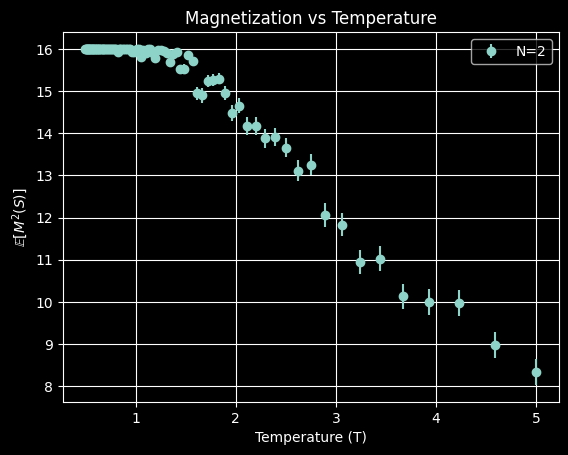

In [46]:
# test some examples
N = 2  # Lattice size
beta_range = np.linspace(0.2, 2, 100)  # Range of inverse temperatures
n_samples = 500  # Number of samples for averaging
tol = 0.01  # Error tolerance

# Simulate and plot magnetization vs temperature
magnetizations, errors = simulate_ising(N, beta_range, n_samples, tol)
plot_results(beta_range, magnetizations, errors, N)

Metropolis Simulating: 100%|██████████| 20/20 [00:10<00:00,  1.92it/s]


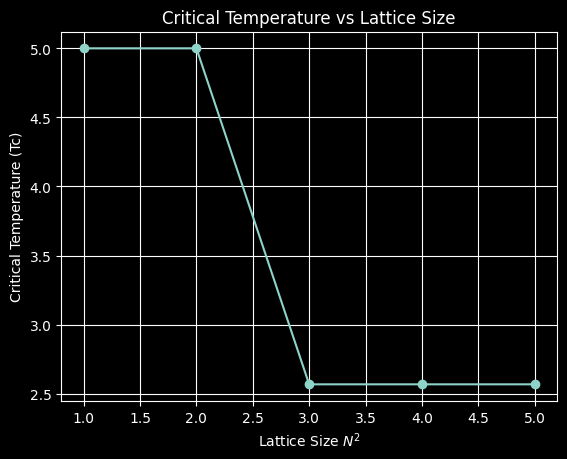

In [47]:
# Critical temperature vs lattice size
N_values = [1,2,3,4,5]
beta_range = np.linspace(0.2, 2, 20)
critical_temperature_vs_size(N_values, beta_range, n_samples, tol)